### EE 564B Homework 1
### Random Search + Gradient Descent Algorithms

### Code from HW1 EE546 Solutions

In [1]:
import numpy as np
import pylab as plt
import scipy as sp
from scipy import linalg as la
import scipy.optimize as opt
import scipy.stats as stats
from scipy.misc import derivative
%matplotlib inline

Text(0.5, 0, 'value of $u$')

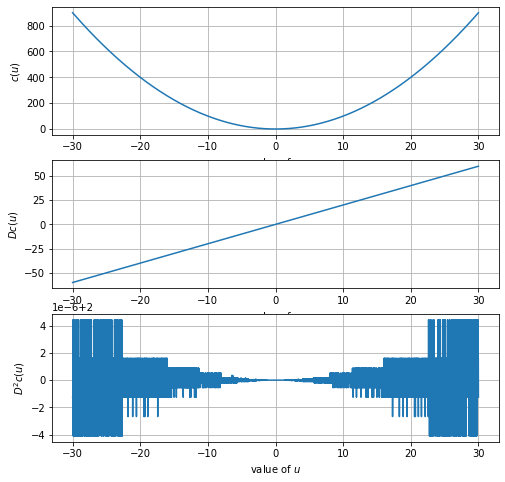

In [2]:
# Set figure properties
figsize = (8,8)
fig = plt.figure(figsize=figsize)

# Define function
# def c(u): return u**6/6.0-7*u**5/5.0+17*u**4/4.0-17*u**3/3.0+3*u**2
def c(u): return (u)**2 
def Dc(u): return derivative(c,u, dx=0.0001)
def DDc(u): return derivative(Dc,u, dx=0.0001)

u = np.linspace(-30,30,10000)
ax1 = plt.subplot(3,1,1); ax1.grid('on')
ax1.plot(u,c(u))
ax1.set_ylabel('$c(u)$')
ax1.set_xlabel('value of $u$')

ax2 = plt.subplot(3,1,2); ax2.grid('on')
ax2.plot(u,Dc(u))
ax2.set_ylabel('$Dc(u)$')
ax2.set_xlabel('value of $u$')

ax3 = plt.subplot(3,1,3); ax3.grid('on')
ax3.plot(u,DDc(u))
ax3.set_ylabel('$D^2c(u)$')
ax3.set_xlabel('value of $u$')

In [3]:
[u_min, c_min,success,iter] = opt.fminbound(c, 0, 6, full_output=True)
print("Approach 1: Using fminbound function:")
print("The minimum c is:    ","%0.6f" % c_min)
print("The minimizing u is: ","%0.6f\n" % u_min)

u_min = u[0]
for u_tmp in u:
  if abs(Dc(u_tmp))<abs(Dc(u_min)) and DDc(u_tmp)>0:
    u_min = u_tmp
print("Approach 2: Based on Dc(u) and D^2c(u) values:")
print("The minimum c is:    ","%0.6f" % c(u_min))
print("The minimizing u is: ","%0.6f\n" % u_min)

u_min = u[0]
for u_tmp in u:
  if c(u_tmp)<c(u_min):
    u_min = u_tmp
print("Approach 3: Directly compare c(u) values:")
print("The minimum c is:    ","%0.6f" % c(u_min))
print("The minimizing u is: ","%0.6f\n" % u_min)

Approach 1: Using fminbound function:
The minimum c is:     0.000000
The minimizing u is:  0.000005

Approach 2: Based on Dc(u) and D^2c(u) values:
The minimum c is:     0.000009
The minimizing u is:  0.003000

Approach 3: Directly compare c(u) values:
The minimum c is:     0.000009
The minimizing u is:  0.003000



Run the (***simple random search***) iteration

$$ u^+ = u - \frac{\gamma}{N \Delta} \sum_{n = 1}^N ( c(u + \Delta u_n) - c(u) ) \cdot u_n,\ u_n \sim \mathcal{N}(u,\sigma^2) $$

starting from multiple initial $u$'s and with multiple values of the parameters $\gamma, \Delta, \sigma > 0$, where $\mathcal{N}(u,\sigma^2)$ denotes a ***normal*** or ***Gaussian*** distribution with mean $u$ and variance $\sigma^2$.  Describe all of the outcomes (i.e. asymptotic behavior of the iteration) you observe and provide plots that illustrate these outcomes.  How should $\sigma$ relate to $\gamma$, $\Delta$?


### Sam's Code

In [13]:
#============================================
def sg(c,u,N,D):
  """
  stochastic gradient
  Dc ~= (1/N) * sum( [(c(u+d[n]) - c(u-d[n])) * d[n] / |d[n]|] for n in range(N) )

  inputs:
    c : U -> R
    u in U - decision variable in vector space U
    N - int - number of samples
    D > 0 - size of displacement

  outputs:
    Dc in N x U - approximations of gradient
  """
  # create displacements
  d = np.random.randn(N,u.size)
#   d /= np.linalg.norm(d,axis=1)[:,np.newaxis]
  d *= D
#   print("Dc")
#   print(d)
#   d = np.random.uniform(-D, D, [N, u.size]) #needs to be N x u.size shape
  d.reshape(tuple([N]+list(u.shape)))
  # compute stochastic gradient
  Dc = np.zeros_like(d)
  for n in range(N):
    Dc[n] = (c(u+d[n]) - c(u-d[n])) * d[n] 
  Dc /= 2*D**2
  return Dc
#============================================

#============================================
def sg_unf(c,u,N,D):
  """
  stochastic gradient
  Dc ~= (1/N) * sum( [(c(u+d[n]) - c(u-d[n])) * d[n] / |d[n]|] for n in range(N) )


  inputs:
    c : U -> R
    u in U - decision variable in vector space U
    N - int - number of samples
    D > 0 - size of displacement

  outputs:
    Dc in N x U - approximations of gradient
  """
  # create displacements
  d = np.random.uniform(-D, D, [N, u.size]) #needs to be N x u.size shape
  d /= np.linalg.norm(d,axis=1)[:,np.newaxis]
  d *= D

  # compute stochastic gradient
  Dc = np.zeros_like(d)
  for n in range(N):
    Dc[n] = (c(u+d[n]) - c(u-d[n])) * d[n] 
  Dc /= 2*D**2
  return Dc
#============================================

#============================================
def gd(c,u0,Dc,g,I):
  """
  gradient descent
  for i in I:
    u -= g(u)*Dc(u)

  inputs:
    c : U -> R
    u0 in U - decision variable in vector space U
    g(u,i) > 0 - step size
    I - int - number of iterations

  outputs:
    U in I x U
  """
  U = np.nan*np.zeros((I,u0.size))
  U.reshape(tuple([I]+list(u0.shape)))
  U[0] = u0
  for i in range(I-1):
    U[i+1] = U[i] - g(U[i],i) * Dc(U[i])
  return U


(50, 1)


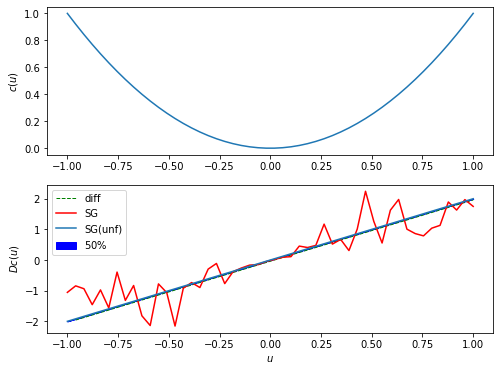

In [16]:
N = 10 # number of samples to draw from
D = 1e-1 # distribution (sigma)

if 1:
  xlim = (-1,+1)
  c = lambda u : u**2 #+ np.random.randn(*u.shape)/10
else:
  c = lambda u : u**6/6-7*u**5/5+17*u**4/4-17*u**3/3+3*u**2
  xlim = (-.2,3.2)

U = np.linspace(*xlim)[:,np.newaxis] # default is to find 50 equally spaces bins in xlim
print(np.shape(U))
cU = c(U)
DcU = np.diff(cU.flatten()) / np.diff(U.flatten())
Dc = np.asarray([sg(c,u,N,D) for u in U]) #Dc = 50 x 100 x 1 = size(U) x N distribution x 1
Dc_unf = np.asarray([sg_unf(c,u,N,D) for u in U]) 

plt.figure(figsize=(8,6))
ax = plt.subplot(2,1,1)
ax.plot(U,cU)
ax.set_ylabel(r'$c(u)$')
ax = plt.subplot(2,1,2)
ax.plot(U[1:],DcU,'g--',lw=1,label='diff')
ax.plot(U,Dc.mean(axis=1),'r',label='SG')
ax.plot(U,Dc_unf.mean(axis=1),label='SG(unf)')

# ax.fill_between(U.flatten(),
#                 np.percentile(Dc,75,axis=1).flatten(),
#                 np.percentile(Dc,25,axis=1).flatten(),
#                 color='gray',label=r'$50\%$')

ax.fill_between(U.flatten(),
                np.percentile(Dc_unf,75,axis=1).flatten(),
                np.percentile(Dc_unf,25,axis=1).flatten(),
                color='blue',label=r'$50\%$')
ax.set_xlabel(r'$u$')
ax.set_ylabel(r'$Dc(u)$')
ax.legend()

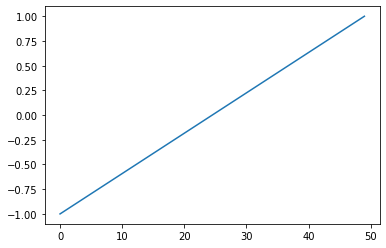

In [6]:
# Stochastic gradient descent
U = np.linspace(*xlim)[:,np.newaxis] # default is to find 50 equally spaces bins in xlim
plt.plot(U)

In [7]:
import random
import time


## Stochastic Error Descent
# This is Equation (4) and Equation (5) in Heliot, 2010
# Derivation is found in Cauwenberghs, 1993 

# This function is one iteration of the error descent calcuation
## INPUT
# input_vect = vector to stochastically perturb
# input_var = FR_VAR, A_VAR OR K_VAR 
# param_dist = distribution from which perturbations to the input are selected
# cost_func = cost function (always reach error)
# cost_func_args = arguments to the cost function (depends on error cost function)
## OUTPUT
# errorGrad = gradient for updating parameter (input vect)
def findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
#     print("sigma = " + str(sigma))
#     print("num_dist = " + str(num_dist))
#     (decoder_params, (curr_fr, targ_vect) ) = cost_func_args
#     (a_vect, k_matx) = decoder_params
    
#     # Get size of input vector
#     num_neurons = np.size(k_matx, 1)
#     num_input_row = np.size(input_vect, 0) 
#     num_input_column = 1
#     if (input_vect.ndim > 1): 
#         num_input_column = np.size(input_vect, 1)
    num_input_row = 1
    num_neurons = 1
    num_input_column = 1
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
#     input_fr = curr_fr.copy().reshape(num_neurons, 1)
#     print("input vect = " + str(input_vect))
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
    
    random.seed(time.time())
    
    perturb_rand = np.random.uniform(-2*sigma, 2*sigma, [num_input_row, num_input_column, num_dist])
#     perturb_rand /= np.linalg.norm(perturb_rand,axis=1)[:,np.newaxis]
#     perturb_rand *= sigma

#     print(np.shape(perturb_rand))

    
#     perturb_rand = np.zeros((num_input_row, num_input_column, num_dist))
    
    
#     for iC in range(num_input_column):
#         for iN in range(num_input_row):
#             random.seed(time.time())
#             perturb_rand[iN, iC, :] = np.random.uniform(0, sigma, num_dist) 
#             # perturb_rand = N_input x N_dist
#             # for each iteration, np.random.normal returns a N_dist x 1 array
    
    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
        
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
#         print("perturb vect:")
#         print(perturb_vect)
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        
        # Case Test: Neuron = 1 (scalar)
        perturb_cost_args = input_perturb
        
#         # Case 1: firing rate
#         # error = reachError(a + K*fr')
#         if (input_var == FR_VAR):        
#             # Calculate error 
#             perturb_cost_args = (decoder_params, (input_perturb, targ_vect) ) 
            
#         # case 2: a
#         # error = reachError(a' + K*fr)
#         elif (input_var == A_VAR):
#             decoder_params_perturb = (input_perturb, k_matx)
#             perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))

#         # case 3: k
#         # error = reachError(a + K'*fr)
#         elif (input_var == K_VAR):
#             decoder_params_perturb = (a_vect, input_perturb)
#             perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))   
        
#         # default: do nothing
#         else:
#             perturb_cost_args = cost_func_args
        
        error_perturb = cost_func(perturb_cost_args)
        error_input = cost_func(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)
    

    error_grad = np.array(error_sum/(num_dist*delta*(sigma**2)))
#     print("error grad = " + str(error_grad))
#     print("==================")
    return error_grad

In [8]:
def cost_func(x):
    return x**2

N = 100
dist = (D, 1, N)
    
# findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args)
EcU = np.asarray([ findErrorGrad(u, 0, dist, cost_func, u)   for u in U]) 

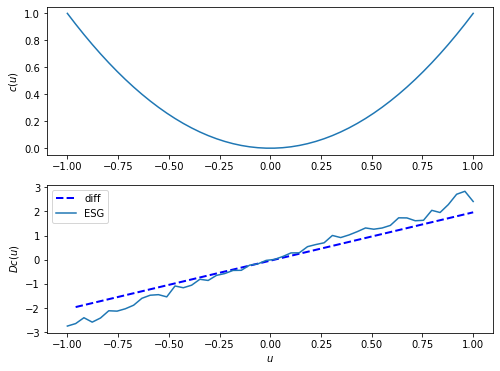

In [9]:
plt.figure(figsize=(8,6))
ax = plt.subplot(2,1,1)
ax.plot(U, cU)
ax.set_ylabel(r'$c(u)$')
ax = plt.subplot(2,1,2)

# plot the derivative of cU
ax.plot(U[1:], DcU, 'b--',lw=2,label='diff')

# ax.plot(U,Dc.mean(axis=1),'r',label='SG')
ax.plot(U, EcU.flatten(), label='ESG')

ax.set_xlabel(r'$u$')
ax.set_ylabel(r'$Dc(u)$')
ax.legend()




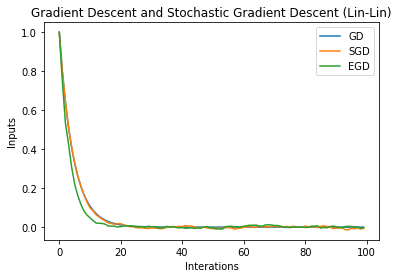

In [10]:
def cost(u): 
    v = u**2
    return v
def Dc(u): return derivative(cost, u, dx=0.0001)

#============================================
def gd(c,u0,Dc,g,I):
  """
  gradient descent
  for i in I:
    u -= g(u)*Dc(u)

  inputs:
    c : U -> R
    u0 in U - decision variable in vector space U
    g(u,i) > 0 - step size
    I - int - number of iterations

  outputs:
    U in I x U
  """
  U = np.nan*np.zeros((I, 1))
  #   U.reshape(tuple([I]+list(u0.shape)))
  U[0] = u0
  for i in range(I-1):
    U[i+1] = U[i] - g * Dc(U[i])
  return U



#============================================
def sgd_unf(c, u, N, D):
  """
  stochastic gradient
  Dc ~= (1/N) * sum( [(c(u+d[n]) - c(u-d[n])) * d[n] / |d[n]|] for n in range(N) )


  inputs:
    c : U -> R
    u in U - decision variable in vector space U
    N - int - number of samples
    D > 0 - size of displacement

  outputs:
    Dc in N x U - approximations of gradient
  """
  # create displacements
  d = np.random.uniform(-D, D, [N, u.size]) #needs to be N x u.size shape
  d /= np.linalg.norm(d,axis=1)[:,np.newaxis]
  d *= D

  # compute stochastic gradient
  Dc = np.zeros_like(d)
  for n in range(N):
    v1 = cost(u + d[n])
#     v2 = cost(u - d[n])
    v2 = cost(u)
    Dc[n] = (v1 - v2) * d[n] 
  Dc /= D**2
  return np.mean(Dc)
#============================================

N = 10 # number of samples to draw from
D = 1e-1 # distribution (sigma)

def sgd_update(c, u0, sgd_c, g, I):
    U = np.nan*np.zeros((I, 1))
    U[0] = u0
    for i in range(I-1):
        U[i+1] = U[i] - g * sgd_c(c, U[i], N , D)
    return U

def egd_update(c, u0, egd, g, I):
    U = np.nan*np.zeros((I, 1))
    U[0] = u0
    for i in range(I-1):
        U[i+1] = U[i] - g * egd(U[i], 0, dist, cost_func, U[i]) 
    return U

# Plain Gradient Descent
# plots u -= g(u)*Dc(u)


gdU = gd(cU, 1 , Dc, .1, 100)
plt.plot(gdU, label='GD')

sgdU = sgd_update(cU, 1, sgd_unf, .1, 100)
plt.plot(sgdU, label='SGD')

egdU = egd_update(cU, 1, findErrorGrad, .1, 100)
plt.plot(egdU, label='EGD')

plt.title("Gradient Descent and Stochastic Gradient Descent (Lin-Lin)")
plt.xlabel("Interations")
plt.ylabel("Inputs")
plt.legend()
plt.show()



Text(0, 0.5, 'Inputs')

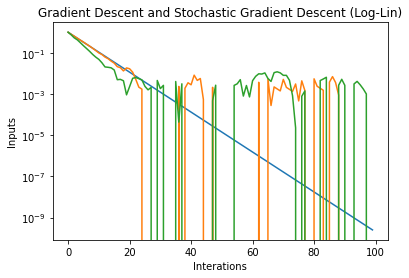

In [11]:
# plt.plot(np.log10(gdU), label='GD')
# plt.plot(np.log10(sgdU), label='SGD')
# plt.plot(np.log10(egdU), label='EGD')

plt.semilogy(gdU, label='GD')
plt.semilogy(sgdU, label='SGD')
plt.semilogy(egdU, label='EGD')
plt.title("Gradient Descent and Stochastic Gradient Descent (Log-Lin)")
plt.xlabel("Interations")
plt.ylabel("Inputs")